# GAN Camel Training

I used clever tricks I adopted on my ML journey to speed up training and get great results, that I will discuss and hopefully you can copy. 

### 1. I've normalized the pictures by dividing by 255, to give the Neural Net easier feature vectors to work with

### 2. I opted to use a Sigmoid function as the output activation instead of Tanh, since this is easier for the Neural Net to squash to(the pictures scale from 0 to 1 after normalizing) in my case

### 3. I'm only sampling from 25,000 to speed up process, because that's enough for this exercise

### 4. I've opted to use a Bilinear upsampling layer, instead of nearest neighbor. This will take into account neighbor pixels when upsampling and do linear interpolation to arrive at the pixel value, instead of just duplicating and copying the values to resize.


## Specifically, I only needed 300 epochs to finalize my training, whereas the book goes through 2000, with all 121,399 pictures(instead of 25,000 like mine). You can see that after 100 epochs, it was already still performant.

This notebook should only take a few hours to run top to bottom

In [1]:
import torch as t
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from models.GAN import build_generator, build_critic

# download your full_numpy_bitmap_camel.npy from below. unfortunately it requires license agreement so I can't automate for you
# https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1

camel_file = 'data/camel/full_numpy_bitmap_camel.npy'
X = t.from_numpy(np.load(camel_file)[:25000]).float()
X = X.view(25000, 1, 28, 28) / 255

bs = 64
z_dim = 100

generator = build_generator(gen_init_size=(64, 7, 7), gen_upsample_flags=[True, True, False, False], 
                            gen_c=[128, 64, 64, 1],gen_ks=[5, 5, 5, 5], gen_strides=[1, 1, 1, 1], 
                            gen_pads=[2, 2, 2, 2], z_dim=z_dim)

critic = build_critic(X[0][None], critic_c=[1, 64, 64, 128, 128], critic_ks=[5, 5, 5, 5], 
                      critic_strides=[2, 2, 2, 1], critic_pads=[2, 2, 2, 2])

g_opt = t.optim.RMSprop(generator.parameters(), lr=.0004)
c_opt = t.optim.RMSprop(critic.parameters(), lr=.0008)
device = t.device('cuda') if t.cuda.is_available() else 'cpu'
generator.cuda(device)
critic.cuda(device)

train_loader = DataLoader(TensorDataset(X, X), batch_size=bs, shuffle=True, drop_last=True)

I had to go back and remove outputs once again, since they take up too much text space. That's why this cell has no execution number attached to it, but everything once again will run top to bottom :)

In [ ]:
imgs_at_epochs = {50: [], 100: [], 150: [], 200: [], 250: [], 300: []}

for epoch in tqdm(range(1, 301)):
    for i, (imgs, _) in enumerate(train_loader):
        # train critic
        real_imgs = imgs.to(device)
        randn = t.randn(bs, z_dim)
        gen_imgs = generator(randn.to(device))

        c_opt.zero_grad()
        ri_pred = critic(real_imgs)
        loss_ri = F.binary_cross_entropy(ri_pred.squeeze(), t.ones(bs).to(device))
        gi_pred = critic(gen_imgs)
        loss_gi = F.binary_cross_entropy(gi_pred.squeeze(), t.zeros(bs).to(device))
        c_loss = (loss_ri + loss_gi) / 2
        c_loss.backward()
        c_opt.step()

        # train generator
        gen_imgs = generator(randn.to(device))

        g_opt.zero_grad()
        gi_critic_pred = critic(gen_imgs)
        g_loss = F.binary_cross_entropy(gi_critic_pred.squeeze(), t.ones(bs).to(device))
        g_loss.backward()
        g_opt.step()

    if epoch in imgs_at_epochs:
        imgs_at_epochs[epoch].extend(generator(t.randn(10, z_dim).to(device)))


In [3]:
t.save(generator.state_dict(), 'models/state_dicts/04_01_gen.pth')
t.save(critic.state_dict(), 'models/state_dicts/04_01_critic.pth')

In [18]:
def plot_imgs(imgs):
    row, col = 3, 3,
    f, axarr = plt.subplots(row, col, figsize=(10, 10))
    i = 0
    for r in range(row):
        for c in range(col):
            axarr[r, c].imshow(imgs[i].detach().cpu().squeeze())
            i += 1

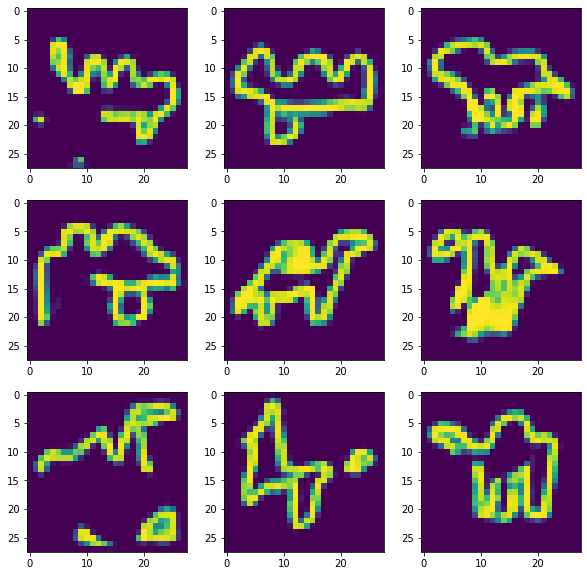

In [19]:
plot_imgs(imgs_at_epochs[50])

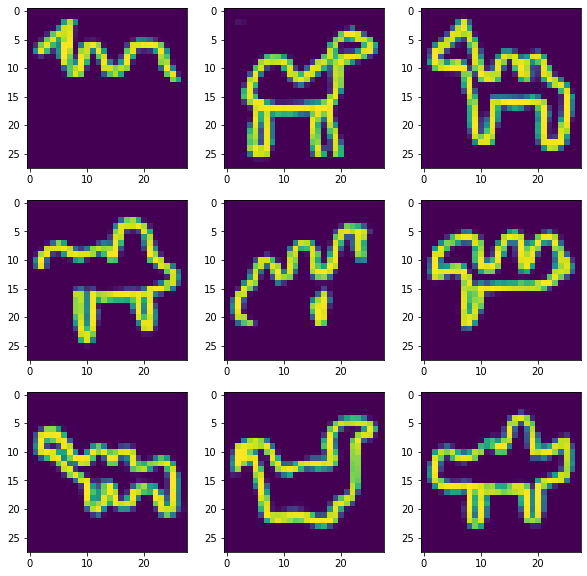

In [20]:
plot_imgs(imgs_at_epochs[100])

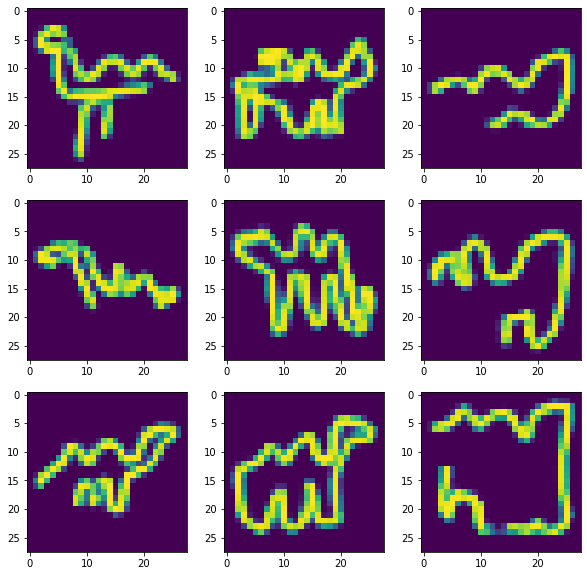

In [21]:
plot_imgs(imgs_at_epochs[200])

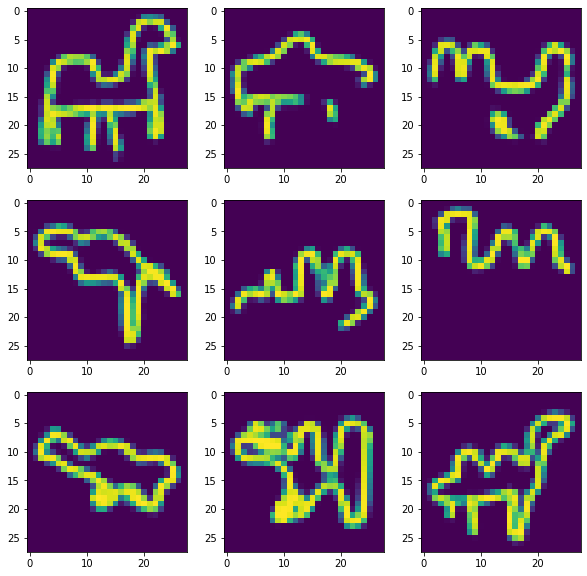

In [22]:
plot_imgs(imgs_at_epochs[300])